<h2><center>Regression and Deep Learning in finance - notebook 2: Basket option in Bachelier</center></h2>

<center>Antoine Savine, October 2019</center>


--- readers running the notebooks on GPU may want to restart Jupyter between notebooks -- running the two notebooks on the same session tends to saturate GPU memory ---


The previous notebook demonstrated that neural nets effectively learn Black & Scholes' pricing from simulated samples, but we also saw that very similar results could be achieved by conventional polynomial (or otherwise fixed basis) regression, much faster and without the need for numerical optimization.

If this is somewhat underwhelming, it is important to remember that neural nets really shine in high dimension (when the dimension of the input $X$ is high). In this case, basis function regression, polynomial or otherwise, suffers the curse of dimensionality and quickly becomes both prohibitively expensive and prone to overfitting the noise in the training set. Neural nets, on the other hand, break the curse of dimensionality by identifying, from the data, a limited set of best representations.

This notebook demonstrates these ideas. We repeat the experience of the previous one, this time, with a basket option in high dimension.

The basket option delivers at $t_2$ a payoff of $max\left(0,w^T S_{t_2}\right)$, where $w$ is a vector of weights (summing to 1) and $S$ a vector of spots (all starting at 100 without loss of generality). 

We simulate all the spots, not in Black & Scholes (where there is no exact analytic for pricing baskets) but in Bachelier's model, also called "normal Black & Scholes". In Bachelier, it is the first differences, not returns, that are Gaussian. The process on stock $i$ is therefore:

$$ dS_i = \sigma_i dW_i $$

And different spots are correlated with a correlation matrix $\rho$.

Pricing of European calls in this model is analytic, like in Black & Scholes, and the price of European calls is given by Bachelier's formula:

$$ C_t = E \left[ \left( S_T - K \right)^+ \lvert S_t \right] = Bach_{K,T-t,\sigma} \left( S_t\right) = \left(S_t - K \right) N \left( d \right) + \sigma \sqrt{T-t} n \left( d \right) $$

where $d = \frac{S_t - K}{\sigma \sqrt{T-t}}$.

It is easy to see that the basket $B_t = w^T S_t$ is also a Gaussian (Bachelier) process with volatility $\sigma_B = \sqrt{w^T C w}$ where $C$ is the covariance matrix between spots: 

$$ C = diag(\sigma) \rho diag(\sigma) $$

Hence, the price of the option on a date $t_1$ where $0<t_1<t_2$, given the vector of the spots on that date, is also given by Bachelier's formula, applied to the current value of the basket:

$$ E \left[ \left( B_{t_2} - K \right)^+ \lvert S_{t_1} \right] = Bach_{K,t_2-t_1,\sigma_B} \left( B_t \right) $$

So this is really a problem in dimension 1: the basket option price only depends on one specific feature of the vector of spots at $t_1$, which is the current basket. Of course, the machine doesn't know that. And it doesn't know Bachelier's model, it doesn't know that data was generated in that model, and, crucially, it doesn't know the weights in the basket (it doesn't even know we are dealing with a basket option). The machine has to figure all that from samples of the (high dimensional) spot vector at $t_1$, together with the corresponding payoff sampled at $t_2$. 

This is a particularly interesting example, where we are going to verify, in a controlled environment (since we know the correct result from Bachelier), how well ML models manage to effectively reduce the dimensionality of the problem and resolve the pricing challenge.

<h3><center>Random generation of model parameters</center></h3>

We (randomly) generate volatility and correlation for a high number of underlying assets.

In [1]:
# dimension of the market
N = 30

import numpy as np

# all spots start at 100 (without loss of generality)
S0_ = np.repeat(100.0, N)

# volatilities
sigma_ = np.random.uniform(low=5.0, high = 20.0, size = N)

# correlations and covariances
correl_ = np.random.uniform(low=-1, high=1, size=(2*N, N))
correl_ = correl_.T.dot(correl_)
diag = np.diagonal(correl_)
norm = 1.0 / np.sqrt(diag)
correl_ = np.diag(norm).dot(correl_).dot(np.diag(norm))

covar_ = np.diag(sigma_).dot(correl_).dot(np.diag(sigma_))

<h3><center>Random generation of a basket option problem</center></h3>

We choose here how many assets we want to effectively simulate, so we can start in low dimension and progressively increase to see how different ML models deal with higher dimension.

We rescale the problem so the volatility of the basket always remains 20. This is so we don't need to rescale our graphs when changing dimensions.

In [2]:
# change dimension here, 1 to 30
dim = 10
#

In [3]:
# market
S0 = S0_[:dim]
sigma = sigma_[:dim]
correl = correl_[:dim,:dim]
covar = covar_[:dim,:dim]

# context
T1 = 1.0
T2 = 2.0

# product
w = np.random.uniform(size=dim)
w = w / np.sum(w)

K = 110.0

# vol of basket
bkt_vol = np.sqrt(np.linalg.multi_dot([w, covar, w]))

# we want to move basket vol to 20 for scale
z = 20.0 / bkt_vol
sigma = sigma * z
covar = covar * z
bkt_vol = bkt_vol * z

# volatility is increased over the first period
sigma_0 = 2 * sigma

<h3><center>Simulation of the training set</center></h3>

Like in the previous notebook, we simulate the training set in NumPy. The code is somewhat more complicated: we have an additional dimension in the asset space and we correlate Gaussian returns before we apply them to generate paths for the assets.

In [4]:
nSimul = 32768

# cholesky of correlation matrix
chol = np.linalg.cholesky(correl)

# simulate all Gaussian differences first, for all time steps (2), simulations (nSimul) and assets (dim)
# increments: tensor of shape [TimeSteps=2, nSimul, dim]
increments = np.random.normal(size=[2, nSimul, dim])

# correlate them
correlated = np.apply_along_axis(lambda v: np.dot(chol, v), 2, increments)

# generate paths, step by step

# vector of all scenarios for all spots at T1, S1, of shape [nSimul, dim]
S1 = S0 + correlated[0,:,:].dot(np.diag(sigma_0))

# the vector of all scenarios for all spots at T2, S2, of shape [nSimul, dim]
S2 = S1 + correlated[1,:,:].dot(np.diag(sigma))

# training set, X, of shape [nSimul, dim] and Y vector of shape [nSimul]
X = S1
B2 = np.dot(S2, w)
Y = np.maximum(0, B2 - K)

<h3><center>Bachelier's formula</center></h3>

We implement Bachelier's formula to assess the performance of ML models against the correct solution.

In [5]:
# normal density and distribution
from scipy.stats import norm

# bachelier, general
def bach(s, vol = bkt_vol):
    d = (s - K) / vol
    return vol * (d * norm.cdf(d) + norm.pdf(d))
    
# bachelier, basket
def bach_bkt(x, vol = bkt_vol):
    bkt = np.dot(x, w)
    return bach(bkt, vol)

<h3><center>Test set</center></h3>

In the previous notebook, we tested results by visualizing predictions on a regular grid in the spot space. We can longer do that in multiple dimensions, because the number of states would increase expoenentially with dimension. Hence, we select random points in the multi-dimensional state space instead. It must be understood that this is not a Monte-Carlo simulation. We sample the $X$ state space, independently of a model, and we only do that randomly to avoid the curse of dimensionality.

More precisely, we independently and randomly sample each spot around their starting value of 100, rescaling common variance so the variance of the basket $w^T X$ is 25. 

For each high-dimensional sample, we compute the corresponding value of the basket $w^T X$ and the correct corresponding price for the option, given by Bachelier's formula. 

Visually, we compare performance of ML models on a scatter plot with baskets on the horizontal axis and prices on the vertical axis. Correct prices are a fixed function (Bachelier) of the basket, hence, the target is a curve on the graph. Incorrectly trained ML models would not have identified this, and may produce thick clouds around the correct curve. 

In [6]:
nTest = 1024

testX = np.random.normal(size=(nTest, dim))
testBkt = testX.dot(w)

z = 25.0 / np.std(testBkt)

testX = S0 + testX * z
testBkt = testX.dot(w)

testLabels = bach(testBkt)

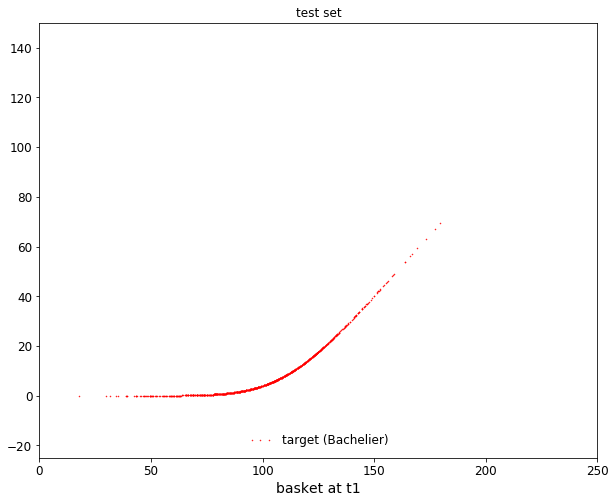

In [7]:
# imports for display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# display
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_xlim(0,250)
ax.set_ylim(-25,150)
ax.set_title("test set")
ax.set_xlabel("basket at t1")
ax.plot(testBkt, testLabels, 'r.', markersize=1, label="target (Bachelier)")

plt.legend(loc="lower center", fontsize="large", numpoints=3, frameon = False)

<h3><center>Linear and polynomial regressions</center></h3>

We reuse the code of the previous notebook.

In [8]:
# polynomial regression in sklearn
from sklearn.preprocessing import PolynomialFeatures  
from sklearn.linear_model import LinearRegression

# simple wrapper class for multi-dimensional polynomial regression
class PolyReg:
    
    def __init__(self, X, Y, degree):
        
        # create monomials
        self.features = PolynomialFeatures(degree = degree)  
        self.monomials = self.features.fit_transform(X)
        
        # regress with normal equation
        self.model = LinearRegression()  
        self.model.fit(self.monomials, Y)

    def predict(self, x):
        
        # predict with dot product
        monomials = self.features.fit_transform(x)
        return self.model.predict(monomials)

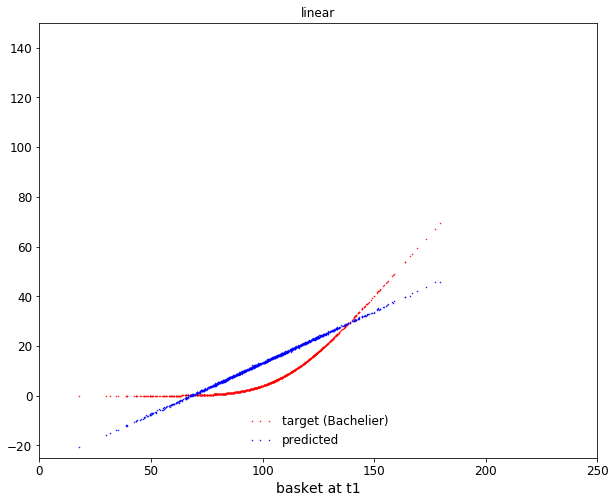

In [9]:
# compute and display test results, linear
degree = 1
polyReg = PolyReg(X, Y, degree) 

# compute
pred = polyReg.predict(testX)

# display
def display(pred, title):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.set_xlim(0,250)
    ax.set_ylim(-25,150)
    ax.set_title(title)
    ax.set_xlabel("basket at t1")
    ax.plot(testBkt, testLabels, 'r.', markersize=1, label="target (Bachelier)")
    ax.plot(testBkt, pred, 'b.', markersize=1, label="predicted")
    plt.legend(loc="lower center", fontsize="large", numpoints=3, frameon = False)

display(pred, "linear")

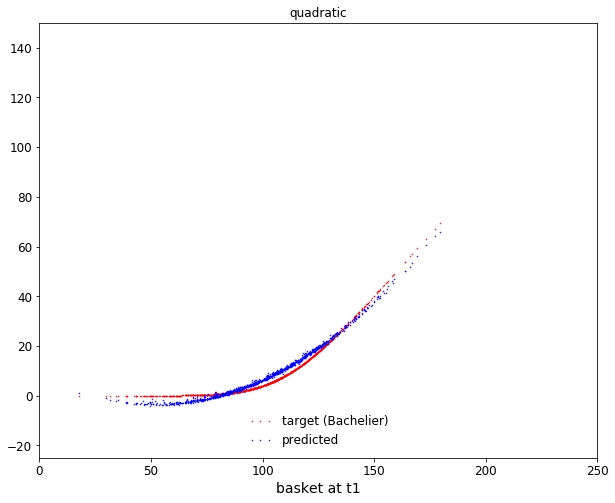

In [10]:
# quadratic
degree = 2
polyReg = PolyReg(X, Y, degree) 
pred = polyReg.predict(testX)
display(pred, "quadratic")

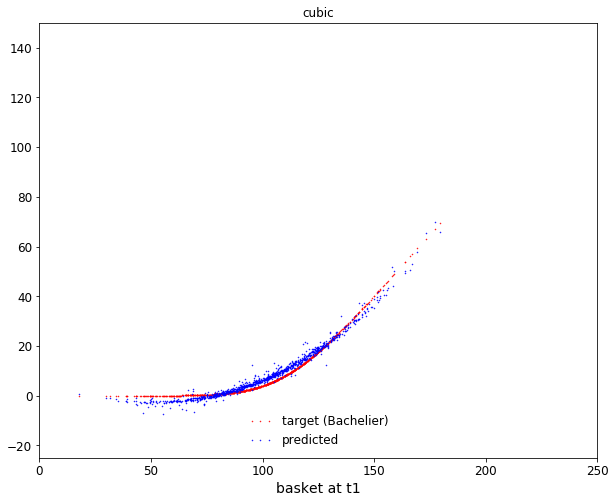

In [11]:
# cubic
degree = 3
polyReg = PolyReg(X, Y, degree) 
pred = polyReg.predict(testX)
display(pred, "cubic")

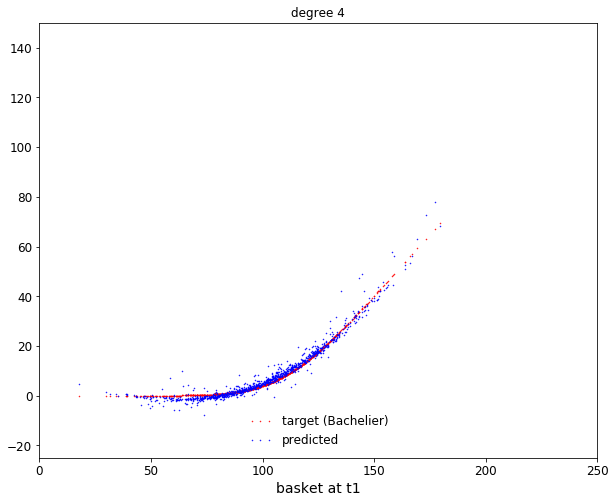

In [12]:
# higher degree here
degree = 4
#
polyReg = PolyReg(X, Y, degree) 
pred = polyReg.predict(testX)
display(pred, "degree " + str(degree))

In low dimension, around 3-5, the performance of polynomial regression (of degree up to 6) matches performance in the Black & Scholes case and instantaneously, and almost perfectly, fits the target curve.

In dimension around 10, things start getting messier. Polynomials of degree 3-4 take several seconds to fit, and produce a somewhat thicker clouds around the target curve, indicating that models work harder only to start overfitting the noise in the training set.

In dimension 20, even quadratic regression starts overfitting, as evidenced in the thickness of its predictions. Cubic regression takes almost half a minute to produce significant randmoness. Degree 4 polynomial takes several minutes to produce what is mainly a random result, overfitted to the randomness of the training set.

In dimension 30, it is quadratic regression that takes several seconds to produce a rather thick cloud, where cubic regression takes several minutes to produce an essentially random result. 

<h3><center>Deep learning</center></h3>

We now see how neural nets fare with high dimension. Importantly, this is the exact same code we used in the previous notebook. We train the exact same neural net, with the same hidden layers (though, obviously, a different input layer). Neural nets adapt representation to data, so (in principle) there is no need to modify them for different problems.

In [13]:
# training works best in normalized space, so we normalized our inputs and labels 

meanX = np.mean(X)
stdX = np.std(X)
meanY = np.mean(Y)
stdY = np.std(Y)

normX = (X - meanX) / stdX
normY = (Y - meanY) / stdY

In [14]:
# start TensorFlow
import tensorflow as tf

# clear calculation graph
tf.reset_default_graph()

In [15]:
# inference = sequence of feed-forward equations from input to output 
# TensorFlow provides higher level function for all kinds of standard layers
# for vanilla layers, the function is tf.layers.dense() 

# the weights and biases are encapsulated and do not explicitly appear in the code

# the argument kernel_initializer allows to control the initialization of the weights
# (the biases are all initialized to 0)
# tf.variance_scaling_initializer() implements the Xavier-He initialization
# (centred Gaussian with variance 1.0 / num_inputs)
# widely considered an effective default, see e.g. Andrew Ng's DL spec on Coursera

def inference(xs):
    
    # hidden layers, note that the weights and biases are encpasulated in the tf functions
    a1 = tf.layers.dense(xs, 3, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a2 = tf.layers.dense(a1, 5, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a3 = tf.layers.dense(a2, 3, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    
    # output payer
    ys = tf.layers.dense(a3, 1, activation = None, kernel_initializer = tf.variance_scaling_initializer)
    
    return ys

In [16]:
# calculation graph for prediction and loss

# the instructions below don't calculate anything, they initialize a calculation graph in TensorFlow's memory space
# when the graph is complete, we can run it in a TensorFlow session, on CPU or GPU

# since TensorFlow knows the calculation graph, it will not only evaluate the results, but also the gradients, 
# very effectively, with the back-propagation equations

# reserve space for inputs and labels
inputs = tf.placeholder(shape=[None,dim], dtype = tf.float32)
labels = tf.placeholder(shape=[None,1], dtype = tf.float32)

# calculation graphs for predictions given inputs and loss (= mean square error) given labels
predictions = inference(inputs)
loss = tf.losses.mean_squared_error(labels, predictions)

In [17]:
# definition of the optimizer
# the optimizer computes the gradient of loss to all weights and biases,
# and modifies them all by a small step (learning rate) in the direction opposite to the gradient
# in order to progressively decrease the loss and identify the set of weights that minimize it

learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate) # optimizer obejct
optimize = optimizer.minimize(loss) #  this op now computes gradient and moves weights
# the op 'optimize' performs one iteration of gradient descent

In [18]:
# we can display predictions before, during and after training
# to do this, we execute the inference result named 'predictions' on the session
# with some arbitrary inputs xs
def predict(xs):
    # first, normalize
    nxs = (xs - meanX) / stdX
    # forward feed through ANN
    nys = sess.run(predictions,feed_dict={inputs:nxs})
    # de-normalize output
    ys = meanY + stdY * nys
    # we get a matrix of shape [size of xs][1], which we reshape as vector [size of xs]
    return np.reshape(ys, [-1])

In [19]:
# now the graph is in memory, TensorFlow's Session object can execute it on a session

# start the session
sess = tf.Session()

# initialize all variables (weights + biases on all layers)
sess.run(tf.global_variables_initializer())

initial loss = 1.1977


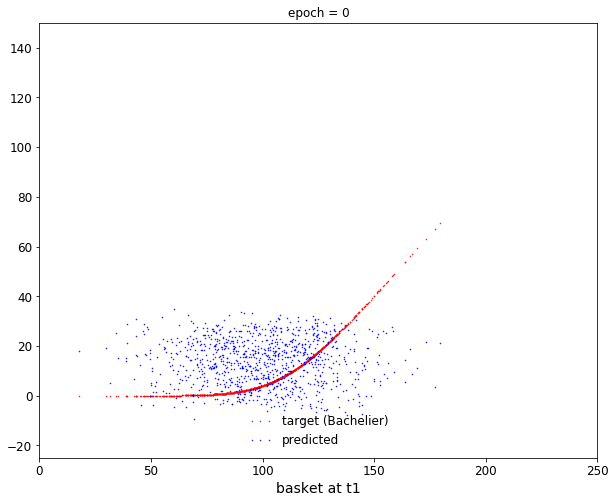

In [20]:
# we want to compute the predictions and losses on the session
# remember the graph has some placeholders for inputs and labels
# we must feed actual values for those into the session

# this is performed with a Python dictionary of placeholder names to concrete values

# we train the network to best predict the ~normalized~ ys out of the ~normalized~ xs
feed_dict = {inputs:normX, labels:normY[:,np.newaxis]}
# TensorFlow expects matrices (possibly with 1 column, not vectors, so we must reshape our vector data with np.newaxis)

# visualize the initial (random) function
display(predict(testX), "epoch = 0")

# compute and display the initial loss
print ("initial loss = %.4f" % sess.run(loss, feed_dict=feed_dict))

final loss = 0.2743


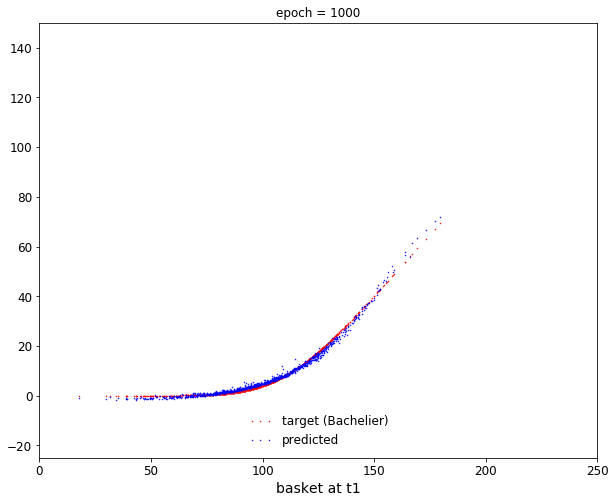

In [21]:
# run the optimizer a few times (called epochs)
epochs = 1000

# we save results after each epoch for visualization
yAxes = [] 

# re-initialize
sess.run(tf.global_variables_initializer())

# go
for _ in range(epochs):
    yAxes.append(predict(testX))
    sess.run(optimize, feed_dict=feed_dict)

# and see improved results
print ("final loss = %.4f" % sess.run(loss, feed_dict=feed_dict))
display(predict(testX), "epoch = " + str(epochs))

# note computation time is not representative, most of the time is spent saving results for visualization
# training alone completes in a fraction of a second

Even with naive batch gradient descent, and without invoking any advanced improvement, the net learns fast (less than a second, most of the time was spent repricing and storing the test set during learning for the animation) and performs remarkably well, hitting the target curve almost perfectly.

Raising dimension from 3 to 30 barely affects the speed and performance. Neural nets effectively break the curse of dimensionality.

Note that advanced improvements, both classical (mini-batch learning, ADAM optimizer...) and specific (differential regularization, asymptotic stabilization, see Deep Analytics here: https://www.slideshare.net/AntoineSavine/deep-analytics) allow to almost instantaneously reproduce the target curve without visible difference.

In [22]:
# create animation to better visualize how the model learns

# create figure
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_xlim(0,250)
ax.set_ylim(-25,150)
ax.plot(testBkt, testLabels, 'r.', markersize=1)
ax.set_title("epoch = 0")
line, = ax.plot(testBkt, yAxes[0], 'b.', markersize=1)

def anim_init():
    ax.set_title("epoch = 0")
    line.set_ydata(yAxes[0])
    return line, 

def anim_update(i):
    ax.set_title("epoch = " + str(i+1))
    line.set_ydata(yAxes[i])
    return line, 

def frames():
    for i in range(49):
        yield i
    for i in range(49, 99, 10):
        yield i
    for i in range(99, epochs, 50):
        yield i

anim = animation.FuncAnimation(fig, anim_update, init_func = anim_init, 
                               frames=frames, interval = 40, blit=True, repeat=False)
plt.close(fig)

anim

In [82]:
sess.close()